In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Data Preparation

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info =True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteWR2ZUU/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmptw48li9rtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

In [ ]:
def splits(dataset, TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  #print(list(train_dataset.as_numpy_iterator()))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(TEST_RATIO*DATASET_SIZE))
  #print(list(test_dataset.as_numpy_iterator()))

  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
  #print(list(val_dataset.as_numpy_iterator()))

  return train_dataset,val_dataset,test_dataset

In [ ]:
TRAIN_RATIO = 0.6
TEST_RATIO = 0.2
VAL_RATIO = 0.2

DATASET_SIZE = len(dataset)
train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Data Visualization

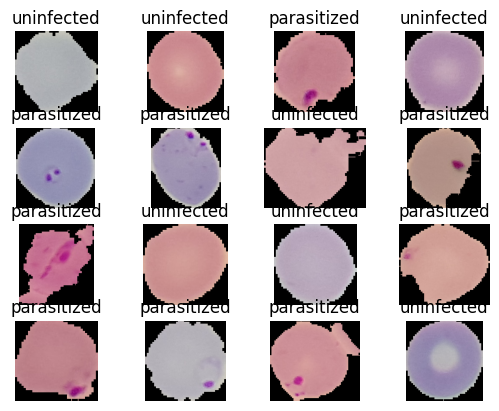

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

Data Preprocessing

In [ ]:
#. We are going to resize (to (224,224) pixels) and normalize our data

IM_SIZE = 224

def resizing_rescale(image,label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0,label

In [ ]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# for image, label in train_dataset.take(1):
#   print(image,label)

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset = test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
                              tf.keras.layers.InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
                              tf.keras.layers.Conv2D(filters=3, kernel_size = 5, strides=1, padding='valid',activation ='sigmoid'),
                              tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
                              tf.keras.layers.BatchNormalization(),

                              tf.keras.layers.Conv2D(filters=3, kernel_size = 5, strides=1, padding='valid',activation ='sigmoid'),
                              tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
                              tf.keras.layers.BatchNormalization(),

                              tf.keras.layers.Flatten(),

                              tf.keras.layers.Dense(1000,activation="sigmoid"),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dense(100,activation="sigmoid"),
                              tf.keras.layers.Dense(1,activation="sigmoid"),

])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 3)       228       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 110, 110, 3)       0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 110, 110, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 3)       228       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 53, 53, 3)         0         
 g2D)                                                            
                                                      

Binary Classification

In [ ]:
y_true = [0,]
y_pred = [0.02,]
bc = tf.keras.losses.BinaryCrossentropy()
bc(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.020202566>

In [ ]:
model.compile(
              optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics = 'accuracy'
)

In [ ]:
history = model.fit(train_dataset,validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
517/517 [==============================] - 40s 70ms/step - loss: 0.6890 - accuracy: 0.5752 - val_loss: 0.7898 - val_accuracy: 0.5012
Epoch 2/10
517/517 [==============================] - 65s 126ms/step - loss: 0.6624 - accuracy: 0.6084 - val_loss: 1.8853 - val_accuracy: 0.4994
Epoch 3/10
517/517 [==============================] - 56s 108ms/step - loss: 0.6973 - accuracy: 0.4924 - val_loss: 0.6942 - val_accuracy: 0.4983
Epoch 4/10
517/517 [==============================] - 49s 96ms/step - loss: 0.6957 - accuracy: 0.4924 - val_loss: 0.6942 - val_accuracy: 0.4986
Epoch 5/10
517/517 [==============================] - 47s 90ms/step - loss: 0.6944 - accuracy: 0.5067 - val_loss: 1.4866 - val_accuracy: 0.4986
Epoch 6/10
517/517 [==============================] - 46s 89ms/step - loss: 0.6954 - accuracy: 0.4951 - val_loss: 0.6936 - val_accuracy: 0.4992
Epoch 7/10
517/517 [==============================] - 64s 124ms/step - loss: 0.6950 - accuracy: 0.4953 - val_loss: 0.6932 - val_accura

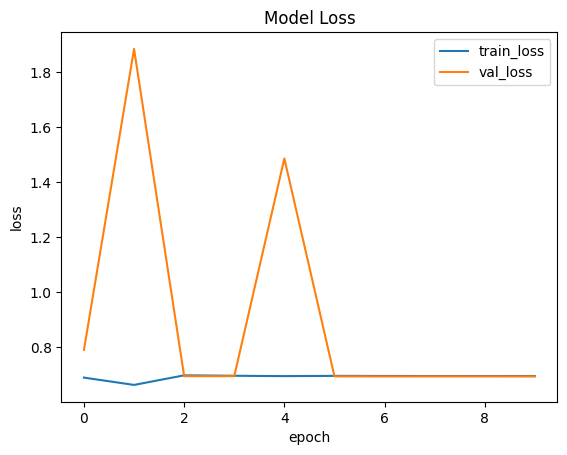

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

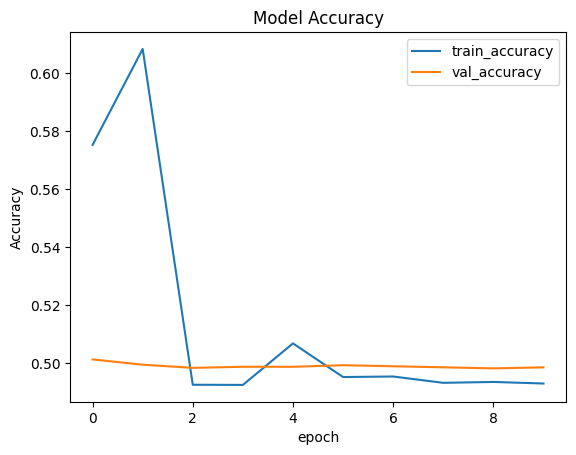

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

Model Evaluation and Testing

In [ ]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.evaluate(test_dataset)

173/173 [==============================] - 17s 42ms/step - loss: 0.6932 - accuracy: 0.5003


[0.6931914687156677, 0.5002720952033997]

In [ ]:
def infection_or_not(x):
  if(x<0.6):
    return str('In') #Infected
  else:
    return str('Un') #Uninfected

In [ ]:
infection_or_not(model.predict(test_dataset.take(1))[0][0]) #Prediction method to see whether our model is able to classify for a new image input

1/1 [==============================] - 10s 10s/step


'In'

1/1 [==============================] - 0s 32ms/step


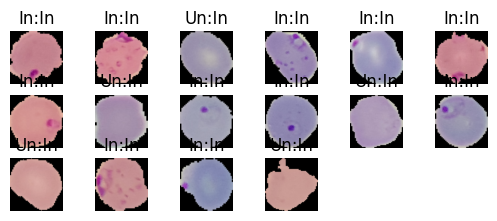

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(6,6,i+1)
  plt.imshow(image[0])
  plt.title(str(infection_or_not(label.numpy()[0])) + ":" + str(infection_or_not(model.predict(image)[0][0]))) #plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')